<a href="https://www.kaggle.com/code/shusrith/worker?scriptVersionId=173546578" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/mobifaller/train.csv")
df1 = pd.read_csv("/kaggle/input/mobifaller/test.csv")
x = df.drop("label", axis=1)
y = [1 if i == 0 else 0 for i in df["label"]]
x

,1,2,3,4,5,6,7,8,9,10,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,167.0,199.0,217.0,226.0,216.0,229.0,232.0,235.0,236.0,236.0,...,133.0,123.0,117.0,115.0,117.0,118.0,118.0,118.0,120.0,125.0
1,171.0,172.0,185.0,204.0,218.0,217.0,208.0,196.0,187.0,180.0,...,154.0,155.0,150.0,143.0,137.0,133.0,130.0,128.0,128.0,129.0
2,120.0,130.0,137.0,142.0,143.0,152.0,153.0,143.0,146.0,165.0,...,109.0,112.0,120.0,126.0,131.0,132.0,152.0,193.0,206.0,181.0
3,122.0,122.0,122.0,123.0,124.0,125.0,125.0,125.0,124.0,124.0,...,113.0,111.0,110.0,110.0,110.0,112.0,114.0,117.0,119.0,118.0
4,162.0,20.0,189.0,161.0,20.0,190.0,160.0,19.0,189.0,159.0,...,205.0,162.0,166.0,204.0,161.0,166.0,204.0,161.0,166.0,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,187.0,184.0,182.0,180.0,176.0,170.0,160.0,152.0,143.0,136.0,...,156.0,159.0,158.0,158.0,159.0,162.0,165.0,167.0,161.0,144.0
7996,173.0,172.0,171.0,170.0,170.0,171.0,171.0,171.0,171.0,170.0,...,95.0,89.0,85.0,83.0,86.0,88.0,92.0,101.0,114.0,127.0
7997,165.0,197.0,211.0,207.0,202.0,206.0,219.0,228.0,232.0,234.0,...,55.0,42.0,38.0,42.0,50.0,60.0,72.0,87.0,105.0,118.0
7998,128.0,128.0,128.0,128.0,128.0,128.0,128.0,129.0,129.0,129.0,...,114.0,116.0,121.0,122.0,117.0,103.0,96.0,89.0,85.0,87.0


In [2]:
from sklearn.model_selection import train_test_split

a, val_input, b, val_output = train_test_split(x, y, test_size=0.5, random_state=42)

In [3]:
from sklearn.neighbors import NearestNeighbors

def nearest_neighbour(neighbours,x):
    n=NearestNeighbors(n_neighbors=neighbours,algorithm="ball_tree")
    n.fit(x)
    dist,indices=n.kneighbors(x)
    return indices
    

In [4]:
import random
def smote(x,neighbours, n):
    k = nearest_neighbour(neighbours, x)
    l = []
    for i in range(len(x)):
        for j in range(n):
            r = random.choice(k[i])
            dist = x[r] - x[i]
            rd = random.random()
            l.append(x[i] + (rd * dist))
    return np.array(l)

In [5]:
y = pd.Series(y)
y.value_counts()

0    7021
1     979
Name: count, dtype: int64

In [6]:
indices=[]
for i, j in enumerate(y):
    if j == 1:
        indices.append(x.iloc[i, :])
indices=np.array(indices)
indices.shape

(979, 1200)

In [7]:
l = smote(indices, 5, 3)
l.shape

(2937, 1200)

In [8]:
x = np.concatenate((l, a), axis=0)
x.shape

(6937, 1200)

In [9]:
y = np.concatenate(([1 for i in range(len(indices) * 3)], b), axis=0)
y.shape

(6937,)

In [10]:
import numpy as np

def tomek_links(x, y):
    n_indices = nearest_neighbour(2, x)
    
    tomek_links_majority = []
    for i in range(len(y)):
        if y[i] != y[n_indices[i][1]] and y[i] == 0:  
            tomek_links_majority.append(i)
    
    xTomek = np.delete(x, tomek_links_majority, axis=0)
    yTomek = np.delete(y, tomek_links_majority, axis=0)
    
    return xTomek, yTomek

In [11]:
x, y = tomek_links(x, y)

In [12]:
q = pd.DataFrame(x)
q["label"] = y
df = q.sample(frac=1)
x = df.drop("label", axis=1)
y = df["label"]
y.value_counts()

label
0    3498
1    3429
Name: count, dtype: int64

In [13]:
x = np.array(x).reshape((x.shape[0], 20, 20, 3))
y = np.array(y)
val_input=np.array(val_input).reshape((val_input.shape[0],20,20,3))
val_output=np.array(val_output)

In [14]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential

model=Sequential()
model.add(Input(shape=(20,20,3)))
model.add(Conv2D(32, (5,5),activation="relu",padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (5,5), activation="relu",padding='same' ))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))
model.summary()

2024-04-23 13:49:26.314891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 13:49:26.314999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 13:49:26.563418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 20, 20, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,201 (3.58 MB)

 Trainable params: 939,201 (3.58 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(F1Score, self).__init__(**kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [16]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[F1Score(),"accuracy"])


In [17]:
model.fit(x,y,epochs=5,validation_data=(val_input,val_output))

Epoch 1/5
 53/217 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6175 - f1_score: 0.6050 - loss: 9.5597 

I0000 00:00:1713880193.363050      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713880193.379776      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7851 - f1_score: 0.7815 - loss: 3.4768

W0000 00:00:1713880199.662771      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713880200.522651      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.7856 - f1_score: 0.7820 - loss: 3.4647 - val_accuracy: 0.9962 - val_f1_score: 0.9848 - val_loss: 0.0137
Epoch 2/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9830 - f1_score: 0.9827 - loss: 0.0447 - val_accuracy: 0.9950 - val_f1_score: 0.9792 - val_loss: 0.0145
Epoch 3/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9878 - f1_score: 0.9878 - loss: 0.0472 - val_accuracy: 0.9970 - val_f1_score: 0.9877 - val_loss: 0.0087
Epoch 4/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9955 - f1_score: 0.9954 - loss: 0.0181 - val_accuracy: 0.9895 - val_f1_score: 0.9551 - val_loss: 0.0313
Epoch 5/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - f1_score: 0.9852 - loss: 0.0535 - val_accuracy: 0.9940 - val_f1_score: 0.9760 - val_loss: 0.0300


In [18]:
from sklearn.metrics import roc_curve, auc
yprob = model.predict(x)
fpr, tpr, thresholds = roc_curve(y, yprob)
J = tpr - fpr
optimum_threshold = thresholds[np.argmax(J)]

114/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1713880204.416045      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1713880205.006869      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [19]:
from sklearn.metrics import classification_report
x1 = df1.drop("label", axis=1)
x1 = np.array(x1).reshape((x1.shape[0], 20, 20, 3))
y1 = [1 if i == 0 else 0 for i in df1["label"]]
y_prob = model.predict(x1)
y_prob = np.array([1 if i >= optimum_threshold else 0 for i in y_prob])
print(classification_report(y_prob, y1, target_names=["fall", "non fall"]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
              precision    recall  f1-score   support

        fall       0.99      1.00      1.00       379
    non fall       0.98      0.96      0.97        56

    accuracy                           0.99       435
   macro avg       0.99      0.98      0.98       435
weighted avg       0.99      0.99      0.99       435



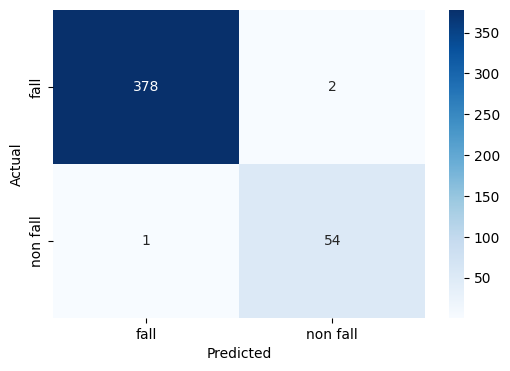

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y1, y_prob)

class_names = ['fall', "non fall"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()